# Similarity method #2

The objective of this notebook is to build a way to measure similarities between intents. 

A first method was previously build and was implementing continuous bags of words (CBOW), which consisted in simply embedding each question as the average of the embeddings of its words (possible modulations of this method consisted in 1. Taking the weighted average with weights being the inverse document frequency of the words, where the idf are computed on a relevant train set, and 2. Only summing the embedding of some words of interests, like nouns, which usually convey most of what people are asking for when asking a question). Once all questions are embedded, we compare the similarity between two questions using a similarity measure (usually cosine similarity).

In this notebook, we try a second method. Rather than summing over all the words of a question and the measuring the similarity with another question, we do as follow:
1. Filter both questions using POS tagging (keeping only nouns for instance)
2. For each filtered word of question 1, measure similarity with each filtered word of question 2 and keep only the highest similarity measure (intuition is, 2 questions would be similar if they ask for the same "objects" with same relationships between those, like 'average', 'number', 'user', 'march'). 
3. Optional step is to apply a non linearity to penalize lower similarities and give more weight to higher similarities (step detailed in the notebook).
4. Consider as similarity score between the two questions the sum of the previously computed pairwise similarities

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gensim
import nltk
import inflect

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
# Load any words embedding
# Here we use word2vec Google pretrained model
# The link to download those embeddings can be found on this page :
# https://github.com/mmihaltz/word2vec-GoogleNews-vectors  (download .gz file in the README)

path = './model/GoogleNews-vectors-negative300.bin'
model = gensim.models.Word2Vec.load_word2vec_format(path, binary=True)

In [4]:
model.similarity('customers','users')

0.59324205934254348

## 1) Introduction

The Objective here is just to show separately which core function we'll use to build our similarity module, and what each function does

### Part of Speech (POS)

Here, we just quickly show how POS functions work.

In [5]:
# POS to keep
keep_pos = ['NN', 'NNS', 'VB','JJ']

# POS tags meaing available at :
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
# FYI, available POS tags :
['PRP$','VBG','VBD','VBN','VBP','WDT','JJ','WP','VBZ','DT','RP','NN','FW','POS',
'TO','LS','RB','NNS','NNP','VB','WRB','CC','PDT','RBS','RBR','CD','PRP','EX','IN',
'WP$','MD','NNPS','JJS','JJR','SYM','UH']

# Question
q = 'how many users are in the base'
q_tokens = nltk.word_tokenize(q)
q_tagged = nltk.pos_tag(q_tokens)
q_tagged_filtered = [q_tagged[i] for i in range(len(q_tagged)) if q_tagged[i][1] in keep_pos]

print q_tagged_filtered

[('many', 'JJ'), ('users', 'NNS'), ('base', 'NN')]


Taking singular forms of nouns is important since similarity(A,A') > similarity(As,A')

In [6]:
print model.similarity('car','car')
print model.similarity('cars','car')

1.0
0.742383054369


In [7]:
p = inflect.engine()

q_singular = []
for pos in q_tagged_filtered:
    if pos[1] != 'NNS':
        q_singular.append(pos[0]) 
    elif pos[1] == 'NNS':
        q_singular.append(p.singular_noun(pos[0]))

print q_singular

['many', 'user', 'base']


### Pairwise similarities non linear transformation

Reason for doing this comes from experimentation observations : usually, semtenticly speaking different words will still have a non-zero similarity (usually < .5 ) wich has a non-negligeable weight when summing over all pairwise similarities (even more if we multiply by the words idf). Hence, we would like to push down those similarities towards 0. Similarly, different but synonyms word will not have 1 similarity (but usually similarities > .5), so we might want to push up those similarities towards 1.  

In [8]:
# pairwise similarity of similar words is not that far from pairwise similarity of non simmilar words
print model.similarity('user','customer')
print model.similarity('user','city')

0.554684003043
0.107564718592


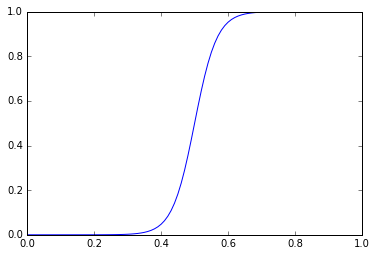

In [9]:
# Most natural non linearity shape we could think about is a sigmoid-like function transposed to [0, 1] --> [0, 1]
m = 30
x_values = [0.01*x for x in range(101)]
y_values = [1/(1+ np.exp(-m*(x-0.5))) for x in x_values]
plt.plot(x_values,y_values)

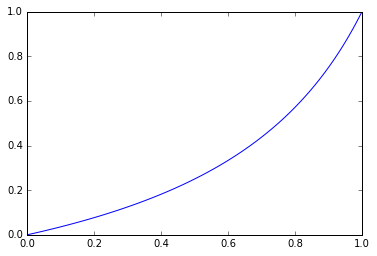

In [10]:
# Other non linearities we can thing of (but is not giving results in practice)
k = 0.5
x_values = [0.01*x for x in range(101)]
y_values = [k*x/(k-x+1) for x in x_values]
plt.plot(x_values,y_values)

In [11]:
def non_linear(x, non_linearity='none'):
    '''
    add a non linearity such as it penalizes values close to 0 (push them even more towards 0)
    'exponential' and 'sigmoid' only refer to the shape of the non linearities, but the functions
    are adapted to fit on [0,1] --> [0,1]
    '''
    if non_linearity=='none':
        y = x
    if non_linearity=='exponential':
        k = 0.5
        y = k*x/(k-x+1)
    if non_linearity=='sigmoid':
        m = 20
        y = 1/(1+ np.exp(-m*(x-0.5)))
    return y

In [12]:
# Sigmoid like non linearity enhances the similarities differences 
print model.similarity('user','customer')
print non_linear(model.similarity('user','customer'), non_linearity='sigmoid')
print model.similarity('user','city')
print non_linear(model.similarity('user','city'), non_linearity='sigmoid')

0.554684003043
0.749074067436
0.107564718592
0.000390104537917


## Similarity #2 code

Here we just provide the code implementation of our similarity method #2 explained at the top.
The last cell can be used to play around and make comparisons between 2 user questions and 1 hardcoded question

In [13]:
keep_pos = ['NN', 'NNS', 'VB', 'JJ']

def filter_pos(question):
    '''
    From a sentence, return list of tuples [(word, POS)] if POS in self.keep_pos (by default : noun(s))
    '''
    question_tokens = nltk.word_tokenize(question)
    question_tagged = nltk.pos_tag(question_tokens)
    question_tagged_pos = [question_tagged[i] 
                            for i in range(len(question_tagged)) 
                            if question_tagged[i][1] 
                            in keep_pos]
    return question_tagged_pos

def plural_to_singular(tagged_pos):
    '''
    Putting all nouns to singular form (because similarity(A,A') > similarity(A,As'))
    '''
    p = inflect.engine()
    q_singular = []
    for pos in tagged_pos:
        if pos[1] != 'NNS':
            q_singular.append(pos[0]) 
        else:
            q_singular.append(p.singular_noun(pos[0]))
    return q_singular


def find_sim(question_nouns_1, question_nouns_2, non_linearity='none'):
    max_len = max(len(question_nouns_1), len(question_nouns_2))
    if len(question_nouns_1) == max_len:
        seq1, seq2 = question_nouns_1, question_nouns_2
    else:
        seq1, seq2 = question_nouns_2, question_nouns_1

    similarity = {}
    for word1 in seq1:
        similarities = []
        for word2 in seq2:
            # try except in case word not in model vocabulary
            try:
                similarities.append(model.similarity(word1, word2))
            except:
                continue

        try:
            sim_max = max(similarities)
            word2_sim_max = seq2[similarities.index(sim_max)]
            # apply non linearity
            similarity[(word1, word2_sim_max)] = non_linear(sim_max, non_linearity)
        except:
            continue
            
        print 'max pairwise similarity: ', word1, word2_sim_max, similarity[(word1, word2_sim_max)]

    similarity_score = 0
    if len(similarity.values()) > 0 :
        similarity_score = sum(similarity.values())/len(similarity.values())

    return similarity_score



def find_similarity(question1, question2, non_linearity='none'):
    question_tagged_nouns_1 = filter_pos(question1)
    question_tagged_nouns_2 = filter_pos(question2)
    question_nouns_1 = plural_to_singular(question_tagged_nouns_1)
    question_nouns_2 = plural_to_singular(question_tagged_nouns_2)
    similarity_score = find_sim(question_nouns_1, question_nouns_2, non_linearity)
    print 'sentence similarity score: '
    return similarity_score

In [14]:
sent1 = 'how many vehicles do i have in my database'
sent2 = 'what is the number of cars in the database'
sent3 = 'how many users are in the base \?'

print 'With non_linearity=none \n'
print find_similarity(sent1, sent2, non_linearity='none')
print ' ' 
print find_similarity(sent1, sent3, non_linearity='none')

print ''

print 'With non_linearity=sigmoid \n'
print find_similarity(sent1, sent2, non_linearity='sigmoid')
print ' ' 
print find_similarity(sent1, sent3, non_linearity='sigmoid')

With non_linearity=none 

max pairwise similarity:  many number 0.495196614879
max pairwise similarity:  vehicle car 0.782109646008
max pairwise similarity:  database database 1.0
sentence similarity score: 
0.759102086962
 
max pairwise similarity:  many many 1.0
max pairwise similarity:  vehicle user 0.179300899246
max pairwise similarity:  database user 0.304389234559
sentence similarity score: 
0.494563377935

With non_linearity=sigmoid 

max pairwise similarity:  many number 0.476001528389
max pairwise similarity:  vehicle car 0.996467437451
max pairwise similarity:  database database 0.999954602131
sentence similarity score: 
0.824141189324
 
max pairwise similarity:  many many 0.999954602131
max pairwise similarity:  vehicle user 0.00163580676637
max pairwise similarity:  database user 0.0196041467584
sentence similarity score: 
0.340398185219


## Conclusion

Once tested on our test set, this method did not demonstrated better results than Similarity method # 1 (slightly less good results indeed). Nevertheless, it's flexibility may allow to find many ways to improve it. Adding a sigmoid like non linearity was one.  

NB : For intent detections, it seems that there are some families of words for which it does not seem to work very well: for instance for months, names, ...

In [15]:
print model.similarity('may', 'april')
print model.similarity('november', 'december')

0.0127895358008
0.689945336356


In [16]:
model.similarity('mike', 'peter')

0.12254906958201985

In [17]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [18]:
sim = [0.14084561111646157, 0.49000480176388517, 0.098279597802745949, 0.87636718444262163, 0.77474887667917247, 1.9831920193301404, 1.8915968941565289, 0.85142737808334035, 0.60254578744891174, 1.7189738506990833, 1.7451472221296067, 0.39080231407369825, 0.14982792277025214, 0.53120426944312138, 0.83393535517405293, 0.5631421643406227, 0.27813108743646103, 0.51790169481522708, 0.21841686393752385, 0.14845677438018878, 0.14533496099354068, 0.87636718444262163, 0.93180053767449078, 0.71971704321339025, 0.84521581884656505, 0.89842921578915258, 3.435361850031839, 2.8323696648698924, 1.7540362888168379]
softmax(sim)

array([ 0.00972544,  0.01378946,  0.00932016,  0.02029282,  0.01833201,
        0.06138048,  0.05600813,  0.01979298,  0.01543204,  0.0471283 ,
        0.04837809,  0.01248718,  0.00981319,  0.01436945,  0.01944977,
        0.01483578,  0.0111566 ,  0.01417956,  0.01050989,  0.00979975,
        0.0097692 ,  0.02029282,  0.02144948,  0.01735042,  0.01967041,
        0.02074549,  0.26224043,  0.1434906 ,  0.04881005])

In [19]:
sum(softmax(sim))

1.0

In [23]:
# load data 
import re
import pandas as pd

def clean_str(string):
    """
    Tokenization/string cleaning strings
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip('\n').strip().lower()

def load_test_data(path, file_name):
    df = pd.read_csv(path + file_name, sep='\t', header=None)
    df.columns = ['hardcoded_question', 'user_question']
    for i in df.index:
        df['hardcoded_question'][i] = clean_str(df['hardcoded_question'][i])
        df['user_question'][i] = clean_str(df['user_question'][i])
    return df 

In [25]:
path = 'data2/'
file_name = 'test_set2.tsv'
data = load_test_data(path, file_name)
questions = data['hardcoded_question'].tolist() + data['user_question'].tolist()

In [70]:
def embed_question(question):
    question_tagged_nouns = filter_pos(question)
    question_nouns = plural_to_singular(question_tagged_nouns)
    embedding = np.zeros(model['random'].shape)
    i=0.0
    for word in question_nouns:
        if word in model.vocab:
            i+=1.0
            embedding += model[word]
    embedding /= i
    return embedding

In [71]:
embedded_questions = [embed_question(q) for q in questions]

In [88]:
import csv

with open ('data2/question_embeddings.tsv', 'w') as embeddings:
    writer = csv.writer(embeddings, delimiter='\t')
    for eq in embedded_questions:
        writer.writerow(eq)
        
with open ('data2/questions.tsv', 'w') as embeddings:
    for q in questions:
        embeddings.write(q+'\n')